<a href="https://colab.research.google.com/github/oriac81/Practiques-Cuaderns-Python/blob/main/Classificador_d'imatges_de_gossos_i_gats_amb_Keras_i_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de imágenes de perros y gatos de Keras CNN.

Aquest projecte és un projecte de classificació d'imatges utilitzant aprenentatge profund basat en Xarxes Neuronals Convolucionals (CNNs) amb Keras.
El problema Dogs vs. Cats és un clàssic per a aquells que volen aprofundir en l'aprenentatge profund. Pots trobar un enllaç proporcionat per Microsoft al conjunt de dades utilitzat en aquest projecte [aquí](https://www.microsoft.com/en-us/download/details.aspx?id=54765) .




## Exploració de Dades

### Importació de Llibreries

 * La llibreria  <u>**shutil**</u> proporciona funcions per a tasques de gestió d’arxius, com copiar i eliminar arxius.
 * La llibreria <u>**random**</u> proporciona funcions per generar números aleatoris i seleccionar elements aleatoris d’una llista.
 * La llibreria <u>**os**</u> proporciona funcions per interactuar amb el sistema operatiu, com crear i eliminar directoris.
 * La llibreria <u>**time**</u> proporciona funcions per treballar amb el temps i les dates.
 * El mòdul <u>**Image**</u> de la llibreria PIL proporciona funcions per treballar amb arxius d’imatges.
 * La llibreria <u>**matplotlib.pyplot**</u>  és una interfície senzilla per crear gràfics 2D en Python, ideal per l'anàlisi visual de dades.





In [151]:
import shutil
import random
import os
import time
from PIL import Image
import matplotlib.pyplot as plt

In [152]:
import kagglehub

# Download latest version
#path = kagglehub.dataset_download("karakaggle/kaggle-cat-vs-dog-dataset")

#print("Path to dataset files:", path)

Montar Google Drive en Colab

In [153]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Escrivint algunes funcions útils per gestionar els nostres arxius i directoris

Començarem a programar escrivint algunes funcions que ens ajudaran a explorar i gestionar el nostre conjunt de dades. Aquestes funcions inclouen:


*   `reset_directory` : Elimina el contingut d’un directori.
*   `extract_corrupt_img_files`: Localitza arxius d’imatges corruptes dins d’un directori.
*   `copy_clean`: Copia tots els arxius del directori d’origen al directori de destinació, ignorant els arxius especificats a la llista d’ignorats.
*   `train_test_validation_split`: Divideix un conjunt de dades en tres subconjunts: conjunt d’entrenament, conjunt de validació i conjunt de prova.

*  `split_data_to_dir` : Copia mostres (representades per un diccionari) d’un directori font a un directori de destinació.
*   `display_imgs_from_path`: Mostra una selecció aleatòria d’imatges d’un directori.





In [154]:
import os

def reset_directory(dir_path):
    """
    Reinicia un directori eliminant tot el seu contingut.
    Si el directori no existeix, el crea.

    Args:
        dir_path (str): El path al directori.
    """
    # Check if the directory exists. If not, create it.
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"Directori '{dir_path}' creat.")
        return  # Return since directory created, nothing to reset

    # If the directory is already empty, print a message and return
    if len(os.listdir(dir_path)) == 0 :
        print(dir_path + " ja està buit")
        return

    for filename in os.listdir(dir_path):
        file_path = os.path.join(dir_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [155]:
def extract_corrupt_img_files(dir_path):
  """
  Gets corrupted image files within a directory

    Arguments:
        dir_path: a string representing the path for the target directory

    Returns:
        a list of the paths for the corrupted image files

  """
  i = 0
  beg = time.time()
  corrupted = []
  for filename in os.listdir(dir_path):
    i +=1
    if (i % 50 == 0):
      print(i, end =" ")
    if (i % 1000 == 0):
      print()
    try:
      img = Image.open(dir_path + '/' + filename)
    except:
      corrupted.append(filename)
      continue

  end = time.time()
  print()
  print('*' * 50)
  print("\nTASK FINISHED IN " + str(end - beg) + " seconds ")
  print("{} corrupted files found in {}".format(len(corrupted), dir_path))
  print()
  print('*' * 50)
  return corrupted

In [156]:
def copy_clean(src = '', dest ='', ignore = []):
    """
    Copies all the files from the source directory to the destination directory, ignoring the files specified in the ignore list.

    Parameters:
    src (str): The path of the source directory.
    dest (str): The path of the destination directory.
    ignore (list): A list of file names to ignore.

    Returns:
    None
    """
    beg = time.time()
    print("Copying file from " + src + " to " + dest)
    i = 0
    j = 0
    for filename in (os.listdir(src)):
        i += 1
        if filename not in ignore:
            shutil.copy(src + '/' + filename, dest + '/' + filename)
            j+=1
        if (i % 100 == 0):
            print(i, end = " ")
        if (i % 1000 == 0):
            print()

    end = time.time()
    print()
    print(j)
    print("Copying {} files finished in {} seconds ".format(len(os.listdir(dest)),int(end - beg)))

In [157]:
def train_test_validation_split(data_path = '',test_split = 0.15, validation_split = 0.15):

    """
    Splits a dataset into three subsets: a training set, a validation set, and a test set.

    Parameters:
    data_path (str): The path of the directory containing the dataset.
    test_split (float): The fraction of the dataset to include in the test set.
    validation_split (float): The fraction of the remaining dataset to include in the validation set.

    Returns:
    tuple: A tuple containing three lists of file names: the training set, the test set, and the validation set.
    """

    # Calculate the total number of files in the dataset
    data_size = len(os.listdir(data_path))

    # Calculate the number of files to include in the test and validation sets
    test_size = int(test_split * data_size)
    validation_size = int(validation_split * data_size)



    test_sample = []
    validation_sample = []
    train_sample = []

    # Select a random sample of files for the test set
    test_sample = random.sample(os.listdir(data_path),test_size )

    # Calculate the remaining files that are not in the test set
    train_data = set(os.listdir(data_path)) - set(test_sample)
    train_data = list(train_data)

    # Select a random sample of files from the remaining files for the validation set
    validation_sample = random.sample(train_data,validation_size )

    # Calculate the remaining files that are not in the validation set
    train_sample = set(train_data) - set(validation_sample)
    train_sample = list(train_sample)

    # Print the sizes of the train, test, and validation sets
    print('train size ' + str(len(train_sample)))
    print('test size ' + str(len(test_sample)))
    print('validation size ' + str(len(validation_sample)))

    return train_sample, test_sample , validation_sample



In [158]:
def split_data_to_dir(class_str = '',src_path ='', dest_path ='',samples ={}):
  """
  Copies samples (represented by a dict) from one source directory to a destination directory

    Arguments:
        class_str: a string representing the class
        src_path: a string representing the path for the source directory
        dest_path: a string representing the path for the destination directory
        sample: a python Dict representing either test or train or validation samples

    Returns:
        None

  """

  src_path = src_path + '/' + class_str
  dest_path = dest_path + '/' + class_str
  beg = time.time()
  print(" Sending test samples to  " + dest_path)
  i = 0 # to track haw many imgs are copied
  for filename in samples[class_str]:
    shutil.copy(src_path + '/' + filename, dest_path + '/'+ class_str + "_" + filename)
    i+=1
    if (i % 25 == 0 ):
      print(i, end = " ")
    if (i % 500 == 0):
      print()

  endt = time.time()
  print("nb of test samples for {} is {}".format(class_str, str(i)))
  print("Sending {} test samples complete in {} seconds ".format(str(i),str(endt - beg)))

In [159]:
import matplotlib.pyplot as plt
from cv2 import imread

def display_imgs_from_path(path='', rows = 1, cols = 1):
  """
  Displays random rows * cols images from a directory

  Arguments:
      path: a string representing the path for the directory with the images to displat
      rows: an integer representing the number of rows in the plots figure
      cols: an integer representing the number of columns in the plots figure

  Returns:
      None

  """
  fig = plt.figure(figsize=(8, 5))

  for i , img_name in enumerate(random.sample(os.listdir(path), rows * cols)):
    img = imread(path + '/' + img_name)
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_name[:8])





### Explorant el DataSet

Obtenint el tamany de les dades de cada classe

In [160]:
print("Mostres de gats : {}".format(len(os.listdir("/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/Dog"))))
print("Mostres de gossos : {}".format(len(os.listdir("/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/Cat"))))

Mostres de gats : 12469
Mostres de gossos : 5080


Buscant arxius corruptes:

In [161]:
dog_path = "/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/Dog"
cat_path = "/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/Cat"

corrupted_dog_imgs = extract_corrupt_img_files(dog_path)
corrupted_cat_imgs = extract_corrupt_img_files(cat_path)


50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 
1050 1100 1150 1200 1250 1300 1350 1400 1450 1500 1550 1600 1650 1700 1750 1800 1850 1900 1950 2000 
2050 2100 2150 2200 2250 2300 2350 2400 2450 2500 2550 2600 2650 2700 2750 2800 2850 2900 2950 3000 
3050 3100 3150 3200 3250 3300 3350 3400 3450 3500 3550 3600 3650 3700 3750 3800 3850 3900 3950 4000 
4050 4100 4150 4200 4250 4300 4350 4400 4450 4500 4550 4600 4650 4700 4750 4800 4850 4900 4950 5000 
5050 5100 5150 5200 5250 5300 5350 5400 5450 5500 5550 5600 5650 5700 5750 5800 5850 5900 5950 6000 
6050 6100 6150 6200 6250 6300 6350 6400 6450 6500 6550 6600 6650 6700 6750 6800 6850 6900 6950 7000 
7050 7100 7150 7200 7250 7300 7350 7400 7450 7500 7550 7600 7650 7700 7750 7800 7850 7900 7950 8000 
8050 8100 8150 8200 8250 8300 8350 8400 8450 8500 8550 8600 8650 8700 8750 8800 8850 8900 8950 9000 
9050 9100 9150 9200 9250 9300 9350 9400 9450 9500 9550 9600 9650 9700 9750 9800 9850 9900 9950 10000 
10050 101

Imprimint el arxius corruptes

In [162]:
print(corrupted_dog_imgs)
print(corrupted_cat_imgs)

[]
[]


Creant els directoris de train, test i validation per a cada classe a Google Drive.

In [163]:
"""
os.makedirs('/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/Data/train')
os.makedirs('/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/Data/test')
"""
try:
    os.makedirs('/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/Dataset')

    os.makedirs('/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/train/Cat')
    os.makedirs('/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/test/Cat')

    os.makedirs('/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/train/Dog')
    os.makedirs('/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/test/Dog')

    os.makedirs('/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/validation/Dog')
    os.makedirs('/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/validation/Cat')
except FileExistsError :
    print("files already exists")
    pass

files already exists


Creant directoris al Google Drive per a les dades no corrompudes data

In [165]:
import os

# Check if the directory exists before attempting to create it
if not os.path.exists('/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/Dataset/Cat'):
    os.makedirs('/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/Dataset/Cat')
else:
    print("Directory '/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/Dataset/Cat' already exists.")

# Check if the directory exists before attempting to create it
if not os.path.exists('/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/Dataset/Dog'):
    os.makedirs('//content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/Dataset/Dog')
else:
    print("Directory '/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/Dataset/Dog' already exists.")

Directory '/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/Dataset/Cat' already exists.
Directory '/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/Dataset/Dog' already exists.


In [167]:
original_dataset_path = '/content/drive/My Drive/Colab Notebooks/PetImages/PetImages'
clean_dataset_path = '/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/Dataset'
test_path = '/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/test'
train_path = '/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/train'
validation_path = '/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/validation'

In [168]:
reset_directory(clean_dataset_path +'/Cat')


Copiant les dades "netes" (p.ex. no corrompudes) als seus respectius directoris.

In [169]:
reset_directory(clean_dataset_path +'/Cat')

copy_clean(src = original_dataset_path + '/Cat',
           dest = clean_dataset_path +'/Cat',
           ignore = corrupted_cat_imgs)
print(len(os.listdir(clean_dataset_path +'/Cat')))

/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/Dataset/Cat is already empty
Copying file from /content/drive/My Drive/Colab Notebooks/PetImages/PetImages/Cat to /content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/Dataset/Cat
100 200 300 400 500 600 700 800 900 1000 
1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 
2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 
3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 
4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 

5080
Copying 5080 files finished in 197 seconds 
5080


In [170]:
reset_directory(clean_dataset_path +'/Dog')

copy_clean(src = original_dataset_path + '/Dog',
           dest = clean_dataset_path +'/Dog',
           ignore = corrupted_dog_imgs)
print(len(os.listdir(clean_dataset_path +'/Dog')))

Copying file from /content/drive/My Drive/Colab Notebooks/PetImages/PetImages/Dog to /content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/Dataset/Dog
100 200 300 400 500 600 700 800 900 1000 
1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 
2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 
3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 
4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 
5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 
6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 
7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 
8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 
9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 
10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 
11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 
12100 12200 12300 12400 
12469
Copying 12469 files finished in 588 seconds 
12469



Dividint les dades en conjunts d'entrenament, validació i prova.

In [171]:
cat_train_sample, cat_test_sample , cat_validation_sample = train_test_validation_split(data_path = clean_dataset_path +'/Cat')

train size 3556
test size 762
validation size 762


In [172]:
dog_train_sample, dog_test_sample , dog_validation_sample = train_test_validation_split(data_path = clean_dataset_path +'/Dog')

train size 8729
test size 1870
validation size 1870


In [173]:
test_samples = { 'Cat': cat_test_sample,
                 'Dog': dog_test_sample,
                }

validation_samples = { 'Cat': cat_validation_sample,
                       'Dog': dog_validation_sample,
                      }
train_samples = { 'Cat': cat_train_sample,
                  'Dog': dog_train_sample,
                      }

Enviant els conjunts d'entrenament, validació i prova als seus respectius directoris.

In [174]:
clean_dataset_path = '/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/Dataset'
test_path = '/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/test'
train_path = '/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/train'
validation_path = '/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/validation'

In [175]:
reset_directory(test_path +"/Cat")
split_data_to_dir(class_str = "Cat", src_path = clean_dataset_path, dest_path = test_path, samples = test_samples)
print(len(os.listdir(test_path +"/Cat")))

 Sending test samples to  /content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/test/Cat
25 50 75 100 125 150 175 200 225 250 275 300 325 350 375 400 425 450 475 500 
525 550 575 600 625 650 675 700 725 750 nb of test samples for Cat is 762
Sending 762 test samples complete in 26.054452896118164 seconds 
762


In [176]:
reset_directory(train_path +"/Cat")
split_data_to_dir(class_str = "Cat", src_path = clean_dataset_path, dest_path = train_path, samples = train_samples)
print(len(os.listdir(train_path +"/Cat")))

 Sending test samples to  /content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/train/Cat
25 50 75 100 125 150 175 200 225 250 275 300 325 350 375 400 425 450 475 500 
525 550 575 600 625 650 675 700 725 750 775 800 825 850 875 900 925 950 975 1000 
1025 1050 1075 1100 1125 1150 1175 1200 1225 1250 1275 1300 1325 1350 1375 1400 1425 1450 1475 1500 
1525 1550 1575 1600 1625 1650 1675 1700 1725 1750 1775 1800 1825 1850 1875 1900 1925 1950 1975 2000 
2025 2050 2075 2100 2125 2150 2175 2200 2225 2250 2275 2300 2325 2350 2375 2400 2425 2450 2475 2500 
2525 2550 2575 2600 2625 2650 2675 2700 2725 2750 2775 2800 2825 2850 2875 2900 2925 2950 2975 3000 
3025 3050 3075 3100 3125 3150 3175 3200 3225 3250 3275 3300 3325 3350 3375 3400 3425 3450 3475 3500 
3525 3550 nb of test samples for Cat is 3556
Sending 3556 test samples complete in 70.27970314025879 seconds 
3556


In [177]:
reset_directory(validation_path +"/Cat")
split_data_to_dir(class_str = "Cat", src_path = clean_dataset_path, dest_path = validation_path, samples = validation_samples)
print(len(os.listdir(validation_path  +"/Cat")))

 Sending test samples to  /content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/validation/Cat
25 50 75 100 125 150 175 200 225 250 275 300 325 350 375 400 425 450 475 500 
525 550 575 600 625 650 675 700 725 750 nb of test samples for Cat is 762
Sending 762 test samples complete in 13.261233806610107 seconds 
762


In [178]:
reset_directory(test_path +"/Dog")
split_data_to_dir(class_str = "Dog", src_path = clean_dataset_path, dest_path = test_path, samples = test_samples)
print(len(os.listdir(test_path +"/Dog")))

 Sending test samples to  /content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/test/Dog
25 50 75 100 125 150 175 200 225 250 275 300 325 350 375 400 425 450 475 500 
525 550 575 600 625 650 675 700 725 750 775 800 825 850 875 900 925 950 975 1000 
1025 1050 1075 1100 1125 1150 1175 1200 1225 1250 1275 1300 1325 1350 1375 1400 1425 1450 1475 1500 
1525 1550 1575 1600 1625 1650 1675 1700 1725 1750 1775 1800 1825 1850 nb of test samples for Dog is 1870
Sending 1870 test samples complete in 33.93076467514038 seconds 
1870


In [179]:
reset_directory(train_path +"/Dog")
split_data_to_dir(class_str = "Dog", src_path = clean_dataset_path, dest_path = train_path, samples = train_samples)
print(len(os.listdir(train_path +"/Dog")))

 Sending test samples to  /content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/train/Dog
25 50 75 100 125 150 175 200 225 250 275 300 325 350 375 400 425 450 475 500 
525 550 575 600 625 650 675 700 725 750 775 800 825 850 875 900 925 950 975 1000 
1025 1050 1075 1100 1125 1150 1175 1200 1225 1250 1275 1300 1325 1350 1375 1400 1425 1450 1475 1500 
1525 1550 1575 1600 1625 1650 1675 1700 1725 1750 1775 1800 1825 1850 1875 1900 1925 1950 1975 2000 
2025 2050 2075 2100 2125 2150 2175 2200 2225 2250 2275 2300 2325 2350 2375 2400 2425 2450 2475 2500 
2525 2550 2575 2600 2625 2650 2675 2700 2725 2750 2775 2800 2825 2850 2875 2900 2925 2950 2975 3000 
3025 3050 3075 3100 3125 3150 3175 3200 3225 3250 3275 3300 3325 3350 3375 3400 3425 3450 3475 3500 
3525 3550 3575 3600 3625 3650 3675 3700 3725 3750 3775 3800 3825 3850 3875 3900 3925 3950 3975 4000 
4025 4050 4075 4100 4125 4150 4175 4200 4225 4250 4275 4300 4325 4350 4375 4400 4425 4450 4475 4500 
4525 4550 4575 4600 4625 4650

In [180]:
reset_directory(validation_path +"/Dog")
split_data_to_dir(class_str = "Dog", src_path = clean_dataset_path, dest_path = validation_path, samples = validation_samples)
print(len(os.listdir(validation_path  +"/Dog")))

 Sending test samples to  /content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/validation/Dog
25 50 75 100 125 150 175 200 225 250 275 300 325 350 375 400 425 450 475 500 
525 550 575 600 625 650 675 700 725 750 775 800 825 850 875 900 925 950 975 1000 
1025 1050 1075 1100 1125 1150 1175 1200 1225 1250 1275 1300 1325 1350 1375 1400 1425 1450 1475 1500 
1525 1550 1575 1600 1625 1650 1675 1700 1725 1750 1775 1800 1825 1850 nb of test samples for Dog is 1870
Sending 1870 test samples complete in 34.532909631729126 seconds 
1870



Comprovació ràpida de les mides dels conjunts.

In [181]:
print("Carpetes al test: " + str(len(os.listdir(test_path))))
print("Mostres al test/Cat: " + str(len(os.listdir(test_path + "/Cat"))))
print("Mostres al test/Dog: " + str(len(os.listdir(test_path + "/Dog"))))

print("Carpetes in validation " + str(len(os.listdir(validation_path))))
print("Mostres al validation/Cat: " + str(len(os.listdir(validation_path + "/Cat"))))
print("Mostres al validation/Dog: " + str(len(os.listdir(validation_path + "/Dog"))))

print("Carpetes in train " + str(len(os.listdir(train_path))))
print("Mostres al train/Cat: " + str(len(os.listdir(train_path + "/Cat"))))
print("Mostres al train/Dog: " + str(len(os.listdir(train_path + "/Dog"))))

Folders in test 2
Samples in test/Cat: 762
Samples in test/Dog: 1870
Folders in validation 2
Samples in validation/Cat: 762
Samples in validation/Dog: 1870
Folders in train 2
Samples in train/Cat: 3556
Samples in train/Dog: 8729



Fent una ullada a mostres aleatòries de dades per a cada classe en els conjunts d'entrenament, validació i prova.

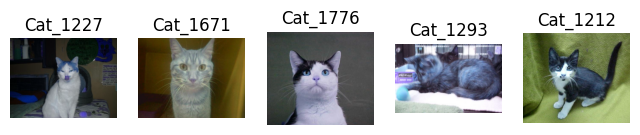

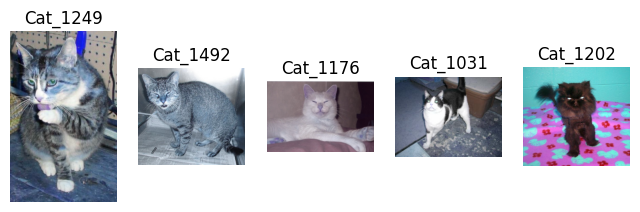

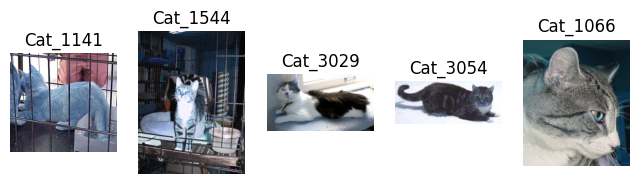

In [182]:
display_imgs_from_path(path=test_path +'/Cat', rows = 1, cols = 5)
display_imgs_from_path(path=train_path +'/Cat', rows = 1, cols = 5)
display_imgs_from_path(path=validation_path +'/Cat', rows = 1, cols = 5)

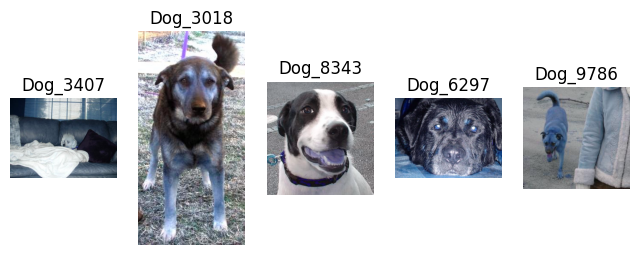

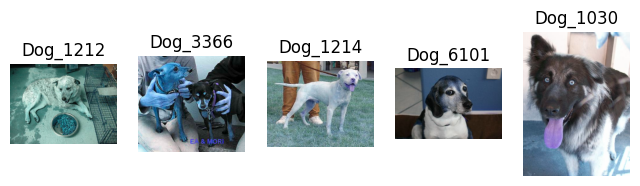

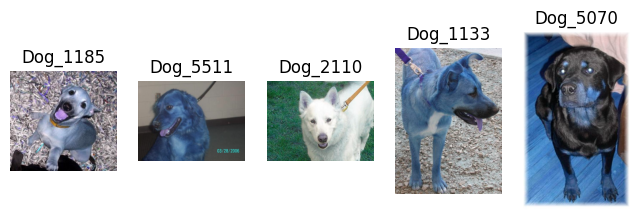

In [183]:
display_imgs_from_path(path=test_path +'/Dog', rows = 1, cols = 5)
display_imgs_from_path(path=train_path +'/Dog', rows = 1, cols = 5)
display_imgs_from_path(path=validation_path +'/Dog', rows = 1, cols = 5)

## Augmentació de dades
En aquest fragment de codi, es creen tres instàncies de la classe `ImageDataGenerator`: `validation_datagen`, `test_datagen`, i `train_datagen`. Aquests objectes es poden utilitzar per generar lots de dades d’imatges per a l’entrenament, la validació i la prova d’un model d’aprenentatge profund.

La classe`ImageDataGenerator`és una classe de conveniència que es pot utilitzar per preprocessar imatges i generar lots de dades d’imatges per entrenar un model. Té diversos paràmetres opcionals que permeten personalitzar la manera com es generen les dades d’imatges.
Aquests paràmetres permeten que l'objecte `train_datagen`  augmenti aleatòriament les dades d’entrenament aplicant diverses transformacions a les imatges, com ara rotació, cisallament, zoom i inversió horitzontal. Això pot ser útil per augmentar la robustesa del model i prevenir el sobreajustament (overfitting).

Les variables `WIDTH`, `HEIGHT`, i `IMG_SIZE` defineixen les dimensions de les imatges que seran processades pels objectes ImageDataGenerator. La variable `BATCH` especifica el nombre d'imatges.


In [184]:
# Import the ImageDataGenerator class
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the image dimensions and Batch size
WIDTH = 128
HEIGHT = 128
IMG_SIZE = (WIDTH , HEIGHT)
BATCH = 32

# Create an ImageDataGenerator object for the validation set
validation_datagen = ImageDataGenerator(rescale=1. / 255)
# Create an ImageDataGenerator object for the test set
test_datagen = ImageDataGenerator(rescale=1. / 255)
# Create an ImageDataGenerator object for the training set

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In this code snippet, a `train_generator` object is created using the `flow_from_directory` method of the `train_datagen` object. The `flow_from_directory` method generates batches of image data from a directory of images, and allows to specify the dimensions of the images, the classes (or labels) of the images, and other parameters that control how the data is generated.

The train generator has found 17502 images belonging to 2 classes.

In [185]:
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size = IMG_SIZE,
                                                    classes=['Cat' , 'Dog'],
                                                    class_mode='binary',
                                                    batch_size=BATCH,
                                                    #save_to_dir=aug_data_path,
                                                    #save_prefix='aug_',
                                                    #save_format="jpg",
                                                    seed = 1

                                                    )
print(train_generator.class_indices)
print(train_generator.num_classes)
print(train_generator.samples)

Found 12285 images belonging to 2 classes.
{'Cat': 0, 'Dog': 1}
2
12285


In [186]:
validation_generator = validation_datagen.flow_from_directory(validation_path,
                                                    target_size = IMG_SIZE,
                                                    classes=['Cat' , 'Dog'],
                                                    class_mode='binary',
                                                    batch_size=BATCH,
                                                    seed = 1 )
print(validation_generator.class_indices)

Found 2632 images belonging to 2 classes.
{'Cat': 0, 'Dog': 1}


In [187]:
test_generator = test_datagen.flow_from_directory(test_path,
                                                    target_size = IMG_SIZE,
                                                    classes=['Cat' , 'Dog'],
                                                    class_mode='binary',
                                                    batch_size=BATCH,
                                                    seed = 1 )
print(test_generator.class_indices)

Found 2632 images belonging to 2 classes.
{'Cat': 0, 'Dog': 1}


## Construint el model

En el fragment de codi següent, construïm i compilem el nostre model.
Es defineix una xarxa neuronal convolucional (CNN) utilitzant el model `Sequential` del mòdul tensorflow.keras.models. La CNN consta d'una sèrie de 3 capes convolucionals i de pooling, seguides per una capa totalment connectada (dense).

El mètode`compile` especifica la funció de pèrdua, l'algoritme d'optimització i les mètriques a utilitzar durant l'entrenament del model.

Finalment el nostre model te 12,942,273 paràmetres.

`EarlyStopping`, `ModelCheckpoint`, `ReduceLROnPlateau` i `CSVLogger`  son Callbacks que s'explicaran més detalladament en el següent fragment de codi.

In [188]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau , CSVLogger

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(WIDTH, HEIGHT, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       4,719,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 5,112,001 (19.50 MB)

 Trainable params: 5,110,017 (19.49 MB)

 Non-trainable params: 1,984 (7.75 KB)

In the code snippet below, several callback functions are defined to be used during training of the CNN model.

* The `ReduceLROnPlateau` callback is used to reduce the learning rate of the optimizer when the validation accuracy stops improving.

* The `EarlyStopping` callback is used to stop training when the validation loss stops improving, using the `patience` parameter to specify the number of epochs to wait before stopping training.

* The `ModelCheckpoint` callback is used to save the model weights at the end of each epoch if the validation loss or accuracy improves.

* The `CSVLogger` callback is used to log the training and validation metrics to a CSV file.

The callbacks list is then created to store the defined callback objects. This list will be passed as an argument to the `fit` method of the model object when training the model, to specify which callback functions to use.

## Callbacks

In [189]:
models_path = '/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/Models'
# Check if the directory already exists
if not os.path.exists(models_path):
    # If it doesn't exist, create it
    os.makedirs(models_path)
else:
    # If it exists, print a message or handle it accordingly
    print(f"El Directori'{models_path}' ja existeix.")

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience= 4,
                                            verbose= 1,
                                            factor= 0.75,
                                            min_lr= 0.00001)

early_stopping = EarlyStopping(patience = 10)

"""checkpoint_loss = ModelCheckpoint(filepath = models_path + '/model_best_loss.hdf5',
    monitor = "val_loss",
    save_best_only = True, save_freq= 'epoch' )"""

checkpoint_acc = ModelCheckpoint(filepath = models_path + '/model_best_acc.keras',
    monitor = "val_accuracy",
    save_best_only = True, save_freq= 'epoch' )

filename='log.csv'
history_logger= CSVLogger(filename, separator=",", append=True)


callbacks = [learning_rate_reduction, early_stopping , #checkpoint_loss ,
             checkpoint_acc, history_logger]

Directory '/content/drive/My Drive/Colab Notebooks/PetImages/PetImages/working/Models' already exists.


 ## Entrenant el model


En el fragment de codi següent, el model CNN es fa entrenar utilitzant el mètode`fit` de l'objecte model.
El mètode `fit` retorna un objecte `History` que conté les mètriques d'entrenament i validació per a cada època. L'objecte model es guarda posteriorment al disc utilitzant els mètodes `save_weights` i `save` ,que guarden els pesos del model i l'arquitectura, respectivament, als camins de fitxers especificats.

El temps d'entrenament també es calcula i es mostra per pantalla.

In [ ]:
EPOCHS = 60
beg = int(time.time())

history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples  // BATCH,
        epochs = EPOCHS,
        validation_data = validation_generator,
        validation_steps = validation_generator.samples // BATCH,
        callbacks = callbacks)

end = int(time.time())
t = end - beg
hrs = t // 3600
mins = (t - 3600 * hrs) // 60
secs = t % 60
print("training took {} hrs -- {} mins -- {} secs".format(hrs,mins,secs))
model.save_weights(models_path + '/first_try_weights.h5')
model.save(models_path + '/first_try.h5')

Epoch 1/60
383/383 ━━━━━━━━━━━━━━━━━━━━ 1181s 3s/step - accuracy: 0.6564 - loss: 0.7855 - val_accuracy: 0.6612 - val_loss: 0.6401 - learning_rate: 0.0010
Epoch 2/60
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7188 - loss: 0.5482 - val_accuracy: 0.7500 - val_loss: 0.7114 - learning_rate: 0.0010
Epoch 3/60
383/383 ━━━━━━━━━━━━━━━━━━━━ 1008s 3s/step - accuracy: 0.7483 - loss: 0.5079 - val_accuracy: 0.7603 - val_loss: 0.4877 - learning_rate: 0.0010
Epoch 4/60
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8125 - loss: 0.5216 - val_accuracy: 1.0000 - val_loss: 0.1343 - learning_rate: 0.0010
Epoch 5/60
383/383 ━━━━━━━━━━━━━━━━━━━━ 1023s 3s/step - accuracy: 0.7690 - loss: 0.4709 - val_accuracy: 0.7702 - val_loss: 0.5005 - learning_rate: 0.0010
Epoch 6/60
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 526us/step - accuracy: 0.7188 - loss: 0.5824 - val_accuracy: 1.0000 - val_loss: 0.3035 - learning_rate: 0.0010
Epoch 7/60
383/383 ━━━━━━━━━━━━━━━━━━━━ 954s 2s/step - accuracy: 0.8105 - loss: 

## Model performance and output

We now use the `evaluate` method of the `model` object to evaluate the model on the test data. The `evaluate` method takes as input the test data generator and returns a list of scores, where the first element is the loss and the second element is the accuracy. The loss and accuracy are calculated using the loss function and metrics specified when the model was compiled.

In this case, our model has an accuracy of **94.82 %**

In [ ]:
scores = model.evaluate(test_generator)

The `history` object contains the training and validation metrics for each epoch, stored in the `history` attribute as a dictionary. The `accuracy` and `val_accuracy`, `loss` and `val_loss`  keys of this dictionary contain the training and validation accuracy and loss respectively.

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['lr'])
plt.title('Learning rate')
plt.ylabel('learnin rate')
plt.xlabel('epoch')
plt.legend(['learning rate'], loc='upper left')
plt.show()

### Visualizing results

In [ ]:
labels = ["Cat","Dog"]

In [ ]:
fig = plt.figure(figsize=(8, 5))


for j in range(10):
    i = random.randint(0,1800)
    dog_test_img = cv2.imread(test_path + '/Dog'+'/'+
                              os.listdir(test_path + '/Dog')[i])
    #print(os.listdir(test_path + '/Dog')[5])
    #print(type(dog_test_img))
    #print(dog_test_img.shape)
    dog_test_img = cv2.cvtColor(dog_test_img,cv2.COLOR_BGR2RGB)
    fig.add_subplot(2, 5, j+1)
    plt.imshow(dog_test_img)
    plt.axis('off')

    dog_test_img = cv2.resize(dog_test_img,(128,128))
    dog_test_img = np.reshape(dog_test_img,(1,128,128,3))
    #print(dog_test_img.shape)

    results = model.predict(dog_test_img,verbose = 0)
    results = np.squeeze(results)
    plt.title(labels[results.astype(int)])

    #print(results.astype(int))
    #print(type(results))

In [ ]:
fig = plt.figure(figsize=(8, 5))


for j in range(5):
    i = random.randint(0,1000)
    cat_test_img = cv2.imread(train_path + '/Cat'+'/'+
                              os.listdir(train_path + '/Cat')[i])
    #print(os.listdir(test_path + '/Dog')[5])
    #print(type(dog_test_img))
    #print(dog_test_img.shape)
    cat_test_img = cv2.cvtColor(cat_test_img,cv2.COLOR_BGR2RGB)
    fig.add_subplot(1, 5, j+1)
    plt.imshow(cat_test_img)
    plt.axis('off')

    cat_test_img = cv2.resize(cat_test_img,(128,128))
    cat_test_img = np.reshape(cat_test_img,(1,128,128,3))
    #print(dog_test_img.shape)

    results = model.predict(cat_test_img,verbose = 0)
    results = np.squeeze(results)
    label_idx = np.round(results,1).astype(int)
    plt.title(labels[label_idx])

    #print(results.astype(int))
    #print(type(results))

In [ ]:
from sklearn.metrics import confusion_matrix
for step in range( test_generator.samples // 32):
    (x, y) = next(test_generator)
    print(y)
    print(y.shape)
    print(type(y))
    y = y.astype(int)
    print(y)

    #Predict
    y_prediction = model.predict(x)
    print(y_prediction)
    y_prediction = np.round(y_prediction,1).astype(int)
    print(y_prediction.shape)
    y_prediction = np.reshape(y_prediction,y.shape)
    print(y_prediction)

In [ ]:
from sklearn.metrics import confusion_matrix
ys = []
y_predictions = []

for step in range( test_generator.samples // 32):
    (x, y) = next(test_generator)
    y = y.astype(int)
    ys = ys + list(y)

    #Predict
    y_prediction = model.predict(x)
    #print(y_prediction)
    y_prediction = np.round(y_prediction,1).astype(int)
    #print(y_prediction.shape)
    y_prediction = np.reshape(y_prediction,y.shape)
    y_predictions  = y_predictions + list(y_prediction)
    #print(y_prediction)

In [ ]:
#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(ys, y_predictions , normalize='pred')
print(cm)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
plt.show()

## Conclusion

Our models has a final test accuracy of 94.82 % despite having a rather simple CNN model architecture.
Additionally, our model has avoided overfitting, which was evident in the preceding plots.This was largely due to the use of early stopping and some regularization techniques we employed such as dropout and batch normalization.

Not bad for a first try! This example clearly demostrates the power of CNN models for image classification tasks.
However there is plenty of room for improvement, such as fine-tuning our model's hyperparameters. We can also resort to fine-tuning a pre-trained model, which can often lead to better performance than training a model from scratch.